Import needed libraries.

In [1]:
import numpy as np
import pandas as pd
import requests
import html5lib
from bs4 import BeautifulSoup
import json

from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

Installing folium because it's giving errors that it's not known.

In [2]:
 !pip install folium

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [3]:
import folium

Import data.

In [4]:
uri = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
pg = requests.get(uri).text
soup = BeautifulSoup(pg, 'lxml')
tbl = soup.find('table')

Load data and clean not assigned rows.

In [5]:
df = pd.read_html(str(tbl))[0]
df.columns = df.iloc[0]
df = df[1:]
df.rename({"Postcode": "PostalCode", "Neighbourhood": "Neighborhood"}, axis=1, inplace=True)
df = df[df.Borough != 'Not assigned']
df.loc[df['Neighborhood'] == 'Not assigned', ['Neighborhood']] = df['Borough']
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
df.shape

(103, 3)

Load csv file with geospatial data.

In [7]:
crds = pd.read_csv('https://cocl.us/Geospatial_data')

Load the dataframe with postal code data.

In [8]:
crds.rename({'Postal Code':'PostalCode'}, axis=1, inplace=True)
df = pd.merge(df, crds, on='PostalCode', how='inner')
df.head(100)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


Limit dataframe to Toronto only data.

In [9]:
df_toronto = df[df['Borough'].str.contains('Toronto')]
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Set up map.

In [10]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [11]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_toronto)  
    
map_toronto

Including a map image because the original rendering didn't show up when I uploaded to Github.

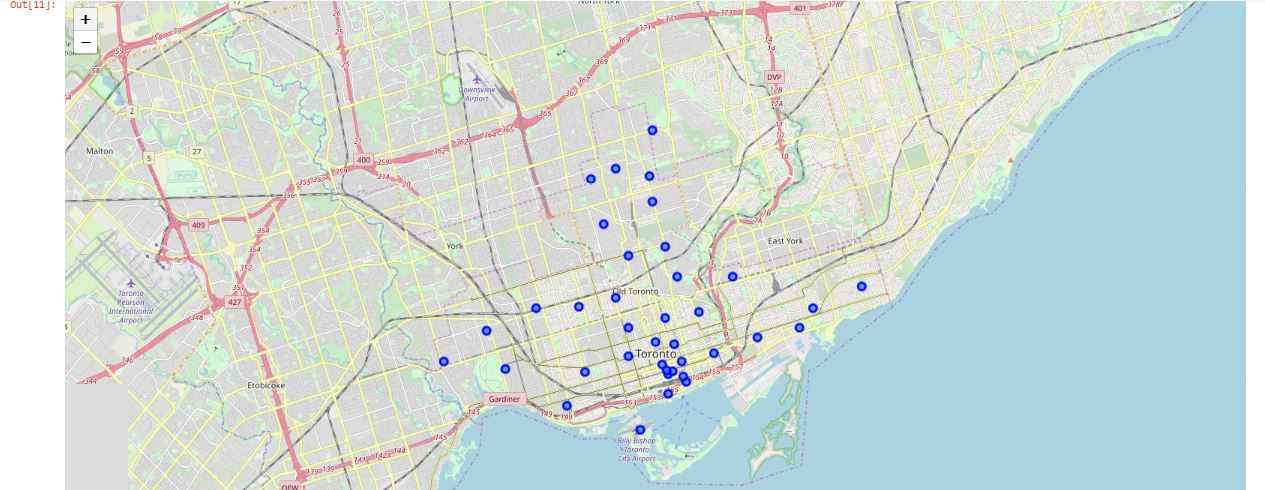

In [29]:
# The code was removed by Watson Studio for sharing.

In [30]:
# Declaring some functions to do our neighborhood analysis with.
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude',
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Find venues in the neighborhoods.

In [14]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )
toronto_venues.head()

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


Use onehot encoding to set the data up for analysis.

In [16]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Grouping
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.00000,0.00,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.00
1,Berczy Park,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.00000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.045455,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.052632,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.011364,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.00000,0.00,0.011364,0.000000,0.011364,0.000000,0.011364,0.000000,0.00
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.010000,0.00000,0.00,0.060000,0.000000,0.000000,0.030000,0.010000,0.000000,0.00
8,Christie,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011494,0.011494,0.011494,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.00000,0.00,0.000000,0.011494,0.000000,0.011494,0.000000,0.011494,0.00


In [19]:
# Start to analysis
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Café,Coffee Shop,American Restaurant,Steakhouse,Bar,Gym,Thai Restaurant,Bakery,Burger Joint,Hotel
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Café,Cheese Shop,Farmers Market,Steakhouse,Bakery,Beer Bar,Italian Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Yoga Studio,Italian Restaurant,Convenience Store,Pet Store,Climbing Gym,Restaurant,Caribbean Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Pizza Place,Gym / Fitness Center,Recording Studio,Restaurant,Butcher,Burrito Place,Brewery,Skate Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Coffee Shop,Sculpture Garden,Bar,Boutique,Plane,Airport Gate


In [20]:
# Run K-means
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4,
       0, 1, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Other Great Outdoors,Pub,Trail,Falafel Restaurant,Event Space,Ethiopian Restaurant,Farmers Market,Diner,Fast Food Restaurant
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Pizza Place,Brewery,Bubble Tea Shop,Café
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Park,Pizza Place,Italian Restaurant,Pet Store,Gym,Pub,Movie Theater,Sandwich Place,Burrito Place,Burger Joint
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Gym / Fitness Center,Brewery,Seafood Restaurant
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Swim School,Bus Line,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


In [22]:
# create map showing clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Including a map image because the original rendering didn't show up when I uploaded to Github.

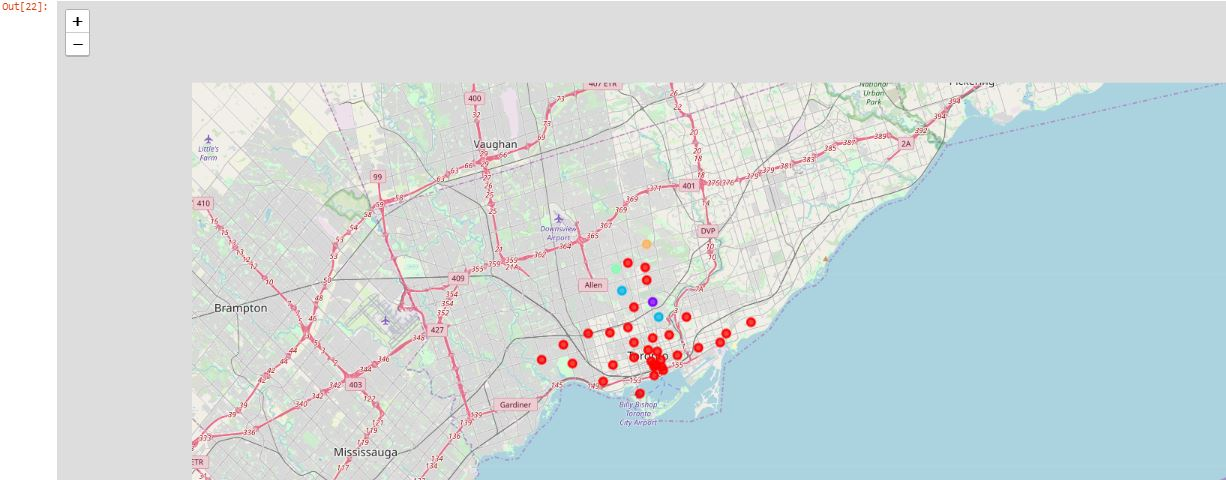

Analyze the clusters and classify them.

In [23]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,0,Health Food Store,Other Great Outdoors,Pub,Trail,Falafel Restaurant,Event Space,Ethiopian Restaurant,Farmers Market,Diner,Fast Food Restaurant
41,East Toronto,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Pizza Place,Brewery,Bubble Tea Shop,Café
42,East Toronto,0,Park,Pizza Place,Italian Restaurant,Pet Store,Gym,Pub,Movie Theater,Sandwich Place,Burrito Place,Burger Joint
43,East Toronto,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Gym / Fitness Center,Brewery,Seafood Restaurant
45,Central Toronto,0,Playground,Hotel,Food & Drink Shop,Clothing Store,Park,Sandwich Place,Breakfast Spot,Grocery Store,Gym,Ethiopian Restaurant
46,Central Toronto,0,Coffee Shop,Yoga Studio,Bagel Shop,Fast Food Restaurant,Mexican Restaurant,Diner,Dessert Shop,Park,Clothing Store,Chinese Restaurant
47,Central Toronto,0,Pizza Place,Dessert Shop,Sandwich Place,Sushi Restaurant,Thai Restaurant,Restaurant,Café,Coffee Shop,Italian Restaurant,Deli / Bodega
49,Central Toronto,0,Pub,Coffee Shop,Light Rail Station,Bagel Shop,Fried Chicken Joint,Supermarket,Sports Bar,American Restaurant,Sushi Restaurant,Pizza Place
51,Downtown Toronto,0,Coffee Shop,Restaurant,Park,Café,Italian Restaurant,Bakery,Pub,Pizza Place,Pet Store,Breakfast Spot
52,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Bubble Tea Shop,Burger Joint,Pub,Hotel,Café


Above is the shopping/entertainment area.

In [24]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,1,Playground,Tennis Court,Diner,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


Above is park area.

In [25]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Downtown Toronto,2,Park,Playground,Trail,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
64,Central Toronto,2,Trail,Jewelry Store,Sushi Restaurant,Park,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Women's Store


Above is a recreation/shopping area.

In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,3,Ice Cream Shop,Garden,Women's Store,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


Above is a rcreation/shopping area.

In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,4,Park,Swim School,Bus Line,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


Above is a residential/shopping area.